In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [11]:
import warnings
pd.set_option('mode.chained_assignment', None)  # SettingWithCopyWarning 경고 무시
warnings.simplefilter(action='ignore', category=[FutureWarning, UserWarning]) # FutureWarning 제거

In [12]:
# Load raw dataset
r_train = pd.read_csv("./dataset/raw/train.csv")
r_test = pd.read_csv("./dataset/raw/test.csv")
print("==== Raw train.csv ====")
r_train[:3]

==== Raw train.csv ====


,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156


In [13]:
print("==== Raw test.csv ====")
r_test[:3]

==== Raw test.csv ====


,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1
1,2021-01-02,NaN,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4
2,2021-01-03,NaN,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5


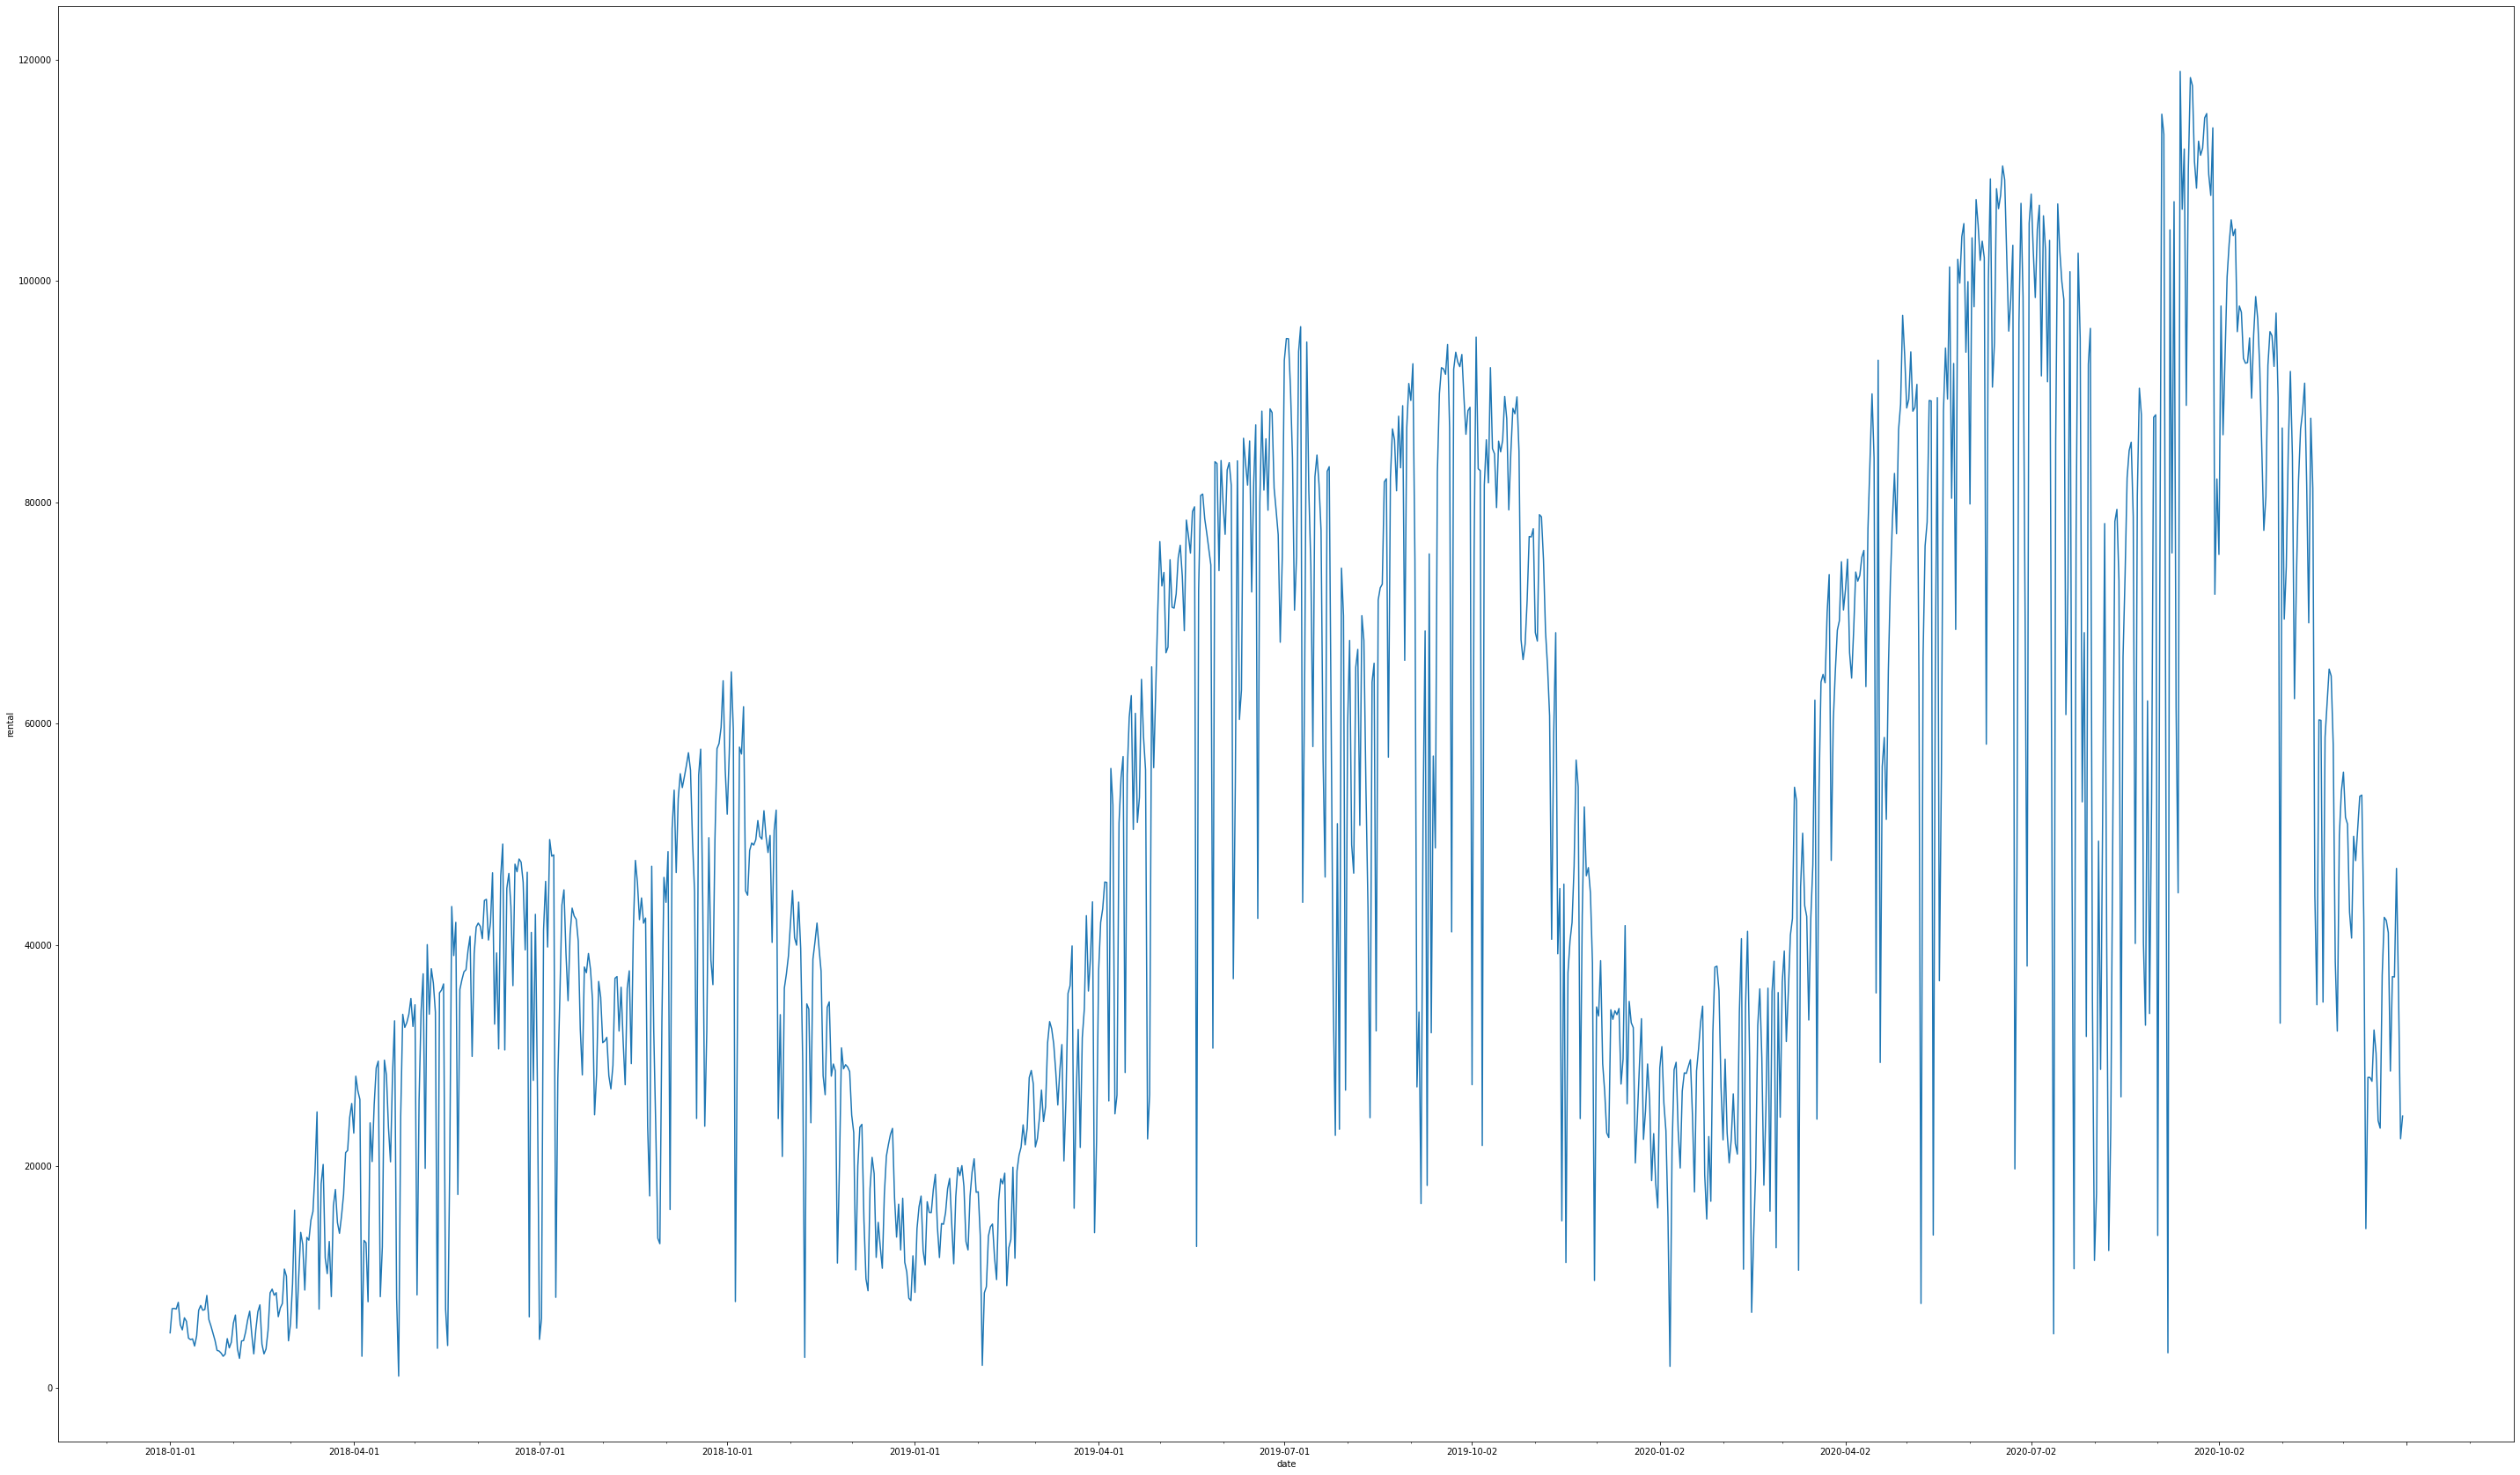

In [14]:
# 시간에 따른 데이터 양상
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline
# x:date, y:rent
xs = r_train['date'].to_list()
ys = r_train['rental'].to_list()


fig = plt.figure(figsize=(50, 30))
ax = fig.add_subplot()
plt.xlabel("date")
plt.ylabel("rental")
# ax = fig.add_subplot()
ax.plot(xs, ys)
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) # 날짜 표시 형식
ax.xaxis.set_major_locator(MonthLocator(interval=3))     # 3개월마다 눈금 표시
ax.xaxis.set_minor_locator(MonthLocator(interval=1)) ## 1개월마다 서브 눈금을 표시한다.

In [15]:
# date 분리 in train
train = r_train
train['date'] = pd.to_datetime(train['date'])
train['year'] = r_train['date'].dt.year
train['month'] = r_train['date'].dt.month
train['day'] = r_train['date'].dt.day
train = train.drop(['date'], axis=1)

In [7]:
# # date 분리 in test
# test = r_train
# test['date'] = pd.to_datetime(test['date'])
# test['year'] = r_test['date'].dt.year
# test['month'] = r_test['date'].dt.month
# test['day'] = r_test['date'].dt.day
# test = test.drop(['date'], axis=1)

In [16]:
import seaborn as sns
# raw data heatmap
sns.heatmap(train.corr(), cmap='Blues')

ModuleNotFoundError: No module named 'seaborn'

In [17]:
train[:5]

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,2018,1,1
1,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,2018,1,2
2,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,2018,1,3
3,NaN,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,2018,1,4
4,NaN,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,2018,1,5


In [19]:
# sunshine sum 결측치 처리
nan_idx_ss = train['sunshine_sum'][train['sunshine_sum'].isnull()].index
print("sunshine sum nan indice: ", nan_idx_ss)

tgt_ss = train['sunshine_sum'].dropna().values.reshape(-1, 1)
x_sr = train['sunshine_rate'].drop(nan_idx_ss).values.reshape(-1, 1)

from sklearn.linear_model import LinearRegression

# LR 학습
lreg_ss = LinearRegression()
lreg_ss.fit(x_sr, tgt_ss)

pred_ss = lreg_ss.predict(train['sunshine_rate'].loc[nan_idx_ss].values.reshape(-1, 1))
pred_ss = list(pred_ss)
print(pred_ss)

# Test는 우선 생략
# t_nan_list_ss = test_df['sunshine_sum'][test_df['sunshine_sum'].isnull()].index
# print(t_nan_list_ss)

sunshine sum nan indice:  Int64Index([17, 25, 45, 187, 604], dtype='int64')
[array([0.18883871]), array([0.18883871]), array([0.18883871]), array([0.18883871]), array([0.18883871])]


In [20]:
# PM10, PM2.5, sunshine_sum 결측치 채우기

train["PM10"] = train["PM10"].fillna(train["PM10"].mean())
train["PM2.5"] = train["PM2.5"].fillna(train["PM2.5"].mean())

for nan, pred in zip(nan_idx_ss, pred_ss):
    train["sunshine_sum"].iloc[nan] = pred

In [21]:
# precipitation(강수량) 결측치 채우기
nan_idx_pp= train['precipitation'][train['precipitation'].isnull()].index
print(nan_idx_pp)

tgt_pp = train['precipitation'].dropna()
columns = ['sunshine_rate','sunshine_sum','month']
x_srss = train[columns].drop(nan_idx_pp)

# Scaling
scaler = MinMaxScaler()
scaler.fit(x_srss)
x_scaled = scaler.transform(x_srss)

# LR 학습
lreg_pp = LinearRegression()
lreg_pp.fit(x_scaled, tgt_pp)

x_nanpp = scaler.transform(train[columns].iloc[nan_idx_pp])
pred_pp = lreg_pp.predict(x_nanpp)
pred_pp = list(pred_pp)

for nan, pred in zip(nan_idx_pp, pred_pp):
    train["precipitation"].iloc[nan] = pred

# t_nan_list_pp = test_df['precipitation'][train_df['precipitation'].isnull()].index
# print(t_nan_list_pp)
# t_pp = test_df['precipitation'].dropna()
# t_srss = test_df[['sunshine_rate','sunshine_sum','month']].drop(t_nan_list_pp)

Int64Index([   0,    1,    2,    3,    4,    5,    6,   10,   13,   16,
            ...
            1078, 1079, 1082, 1083, 1084, 1085, 1087, 1088, 1089, 1093],
           dtype='int64', length=678)


In [22]:
# 결측치 전부 채움
train.isnull().sum()

precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
rental           0
year             0
month            0
day              0
dtype: int64

In [23]:
train

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,-4.440156,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,2018,1,1
1,-3.552492,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,2018,1,2
2,-4.954678,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,2018,1,3
3,0.307631,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,2018,1,4
4,-4.067014,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,2018,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.000000,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103,2020,12,27
1091,1.300000,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912,2020,12,28
1092,0.200000,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747,2020,12,29
1093,-0.063275,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,22488,2020,12,30


# 2018\~2019, 2019\~2020년도 각 월별 증가량 추이

In [24]:
train_2018 = train[train['year'] == 2018]
train_2019 = train[train['year'] == 2019]
train_2020 = train[train['year'] == 2020]
s2018 = {}
s2019 = {}
s2020 = {}

# 연도[월] = 해당연도 해당월 렌트량 합
for i in range(1, 13):
    s2018[i] = train_2018[train_2018['month'] == i]['rental'].values.sum()
    s2019[i] = train_2019[train_2019['month'] == i]['rental'].values.sum()
    s2020[i] = train_2020[train_2020['month'] == i]['rental'].values.sum()

In [25]:
# 월별 변화량
d1819 = {}
d1920 = {}
d1820 = {}

for i in range(1, 13):
    d1819[i] = (s2019[i] - s2018[i])/s2018[i]
    d1920[i] = (s2020[i] - s2019[i])/s2019[i]
    d1820[i] = (s2020[i] - s2018[i])/s2018[i]

In [29]:
d1820

{1: 3.8316389542913116,
 2: 3.5174201883359704,
 3: 2.3145975130819325,
 4: 2.1362655094965,
 5: 1.5686690989831287,
 6: 1.2954230844744072,
 7: 1.3477052585646558,
 8: 0.6712912226929026,
 9: 0.9419914322790235,
 10: 1.035460548591074,
 11: 1.0696867082946797,
 12: 1.388690992009137}

In [26]:
from sklearn.linear_model import BayesianRidge
import numpy as np

In [ ]:
# Bayesian Curve Fitting
# from sklearn.model_selection import train_test_split

n_order = 2
columns = ['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'month', 'day']

X = train[columns].values.tolist()
y = train['rental'].values.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1024)

reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

reg.fit(X_train, y_train)

BayesianRidge(compute_score=True, tol=1e-06)

In [ ]:
tmp = reg.predict(X_test)
print(tmp.reshape(-1, 1).shape)
print(np.array(y_test).reshape(-1, 1).shape)

(110, 1)
(110, 1)


In [ ]:
import numpy as np

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [ ]:
y_train = np.array(y_train).reshape(-1, 1)

# for x, y in zip(X_train, y_train):
#     pred = reg.predict(x.reshape(-1, 1))
# #     pred = pred.reshape(-1, 1)
# #     print(pred.shape, y.shape)
#     print(NMAE(y, pred))

pred = reg.predict(X_train)
y_train = y_train.reshape(-1)

NMAE(y_train, pred)

1.449180471266432

In [ ]:
y_train.shape

(985,)